# 4.  Building Neural Networks with Keras
![network](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/1200px-Colored_neural_network.svg.png)

This notebook is an introduction to building neural networks with the [Keras](https://keras.io) API.

# Table of contents
* [Introduction](#introduction)
* [What are neural networks?](#intro-neural-nets)
* [Adding regularization](#regularization)
* [Computer vision: building convolution neural networks for the MNIST dataset](#cnn-mnist)
* [Saving and loading models](#saving)
* [Visualizing networks with TensorBoard](#tensorboard)
* [Additional resources](#additional-resources)

# Introduction <a id="introduction"></a>
One of the biggest recent developments in machine learning is the usage of [_**artificial neural networks**_](https://en.wikipedia.org/wiki/Artificial_neural_network) (ANNs) as a powerful tool in the data scientist's toolbox. Although neural nets have been around for over 70 years, they've only become popular in the past decade thanks to advancements in algorithms and hardware.

On the software side, [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) (aka backwards-mode automatic differentiation), introduced in the 1980s, made it much easier to train neural networks. Later, researchers introduced neural network architectures such as [convolutional networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) and [LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) that saw success in tasks such as handwriting recognition.

Meanwhile, hardware limitations originally made it difficult to train neural networks, which require more data and computing power than most machine learning methods. However, improvements in processor power and the advent of specialized hardware such as graphics processing units have made training neural nets much faster. Massively parallel computing has also enabled boosts in training time: for instance, Google's [AlphaZero](https://en.wikipedia.org/wiki/AlphaZero) was trained on 5,000 tensor processing units in parallel in just a few hours.

In this workshop, we will be using [Keras](https://keras.io) to build our own neural networks. Keras is a high-level interface for building ANNs, with libraries like [TensorFlow](https://www.tensorflow.org) running on the backend.

### Note: you will need to run the following code cell every time you restart this notebook

In [1]:
###
### RUN THIS CELL BEFORE USING THE REST OF THE NOTEBOOK
###
# Set the Keras backend to be TensorFlow
import os, shutil
os.environ['KERAS_BACKEND'] = 'tensorflow'

%matplotlib inline
import matplotlib.pyplot as plt
import numpy             as np
np.random.seed(0)

import plotly.offline    as py
import plotly.graph_objs as go
from   plotly import tools
py.init_notebook_mode(connected=True)

from sklearn.datasets import make_circles

from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers          import l2
from keras.datasets              import mnist
from keras                       import backend
from keras.utils                 import to_categorical
from keras.layers                import Dense, Dropout
from keras.layers                import Conv2D, MaxPooling2D, Flatten
from keras.models                import Sequential, load_model

########## Helper functions
def square_axes(ax, data, expansion_factor=1.05):
    # Change limits of plot axes to center on the input dataset, and to put the
    # x-axis and y-axis on the same scale
    m        = np.mean(data)
    max_dist = max([np.linalg.norm(u-m) for u in data]) * expansion_factor
    lims     = [m-max_dist, m+max_dist]
    try:    ax.set_xlim(lims); ax.set_ylim(lims)
    except: ax.xlim(lims); ax.ylim(lims)

def plot_decision_boundary(X, clf, ax, incr=1, h=.02):
    # Plot the decision boundary for a machine learning classifier on 2D data
    xmin, xmax = X[:,0].min()-incr, X[:,0].max()+incr
    ymin, ymax = X[:,1].min()-incr, X[:,1].max()+incr
    xx, yy     = np.meshgrid(np.arange(xmin,xmax,h),np.arange(ymin,ymax,h))
    Z          = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=.2)

def load_mnist_wrapper(n_classes=10):
    # Loads the MNIST dataset, and does some preprocessing
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Only keep the first n_classes digits
    X_train = X_train[y_train < n_classes]; y_train = y_train[y_train < n_classes]
    X_test  = X_test[y_test < n_classes];   y_test  = y_test[y_test < n_classes]
    
    # Pre-process the data for the backend we're using
    if backend.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
        X_test  = X_test.reshape(X_test.shape[0],   1, 28, 28)
    else:
        X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
        X_test  = X_test.reshape(X_test.shape[0],   28, 28, 1)

    # Change pixel intensities from the range 0 - 255 to the range 0 - 1
    X_train = X_train / 255
    X_test  = X_test  / 255

    # Convert the class labels into a format that Keras will be able to parse
    y_train = to_categorical(y_train, n_classes)
    y_test  = to_categorical(y_test,  n_classes)
    
    return (X_train, y_train), (X_test, y_test)

def lm_vs_ann_helper(x_train, y_train, x_test, y_test, lm, ann):
    """Helper function to compare a linear model against a neural net
    on 2D data. Used for section on regularization."""
    print('ANN training loss:          %5.4f' % mean_squared_error(y_train, ann.predict(x_train)))
    print('ANN testing loss:           %5.4f' % mean_squared_error(y_test,  ann.predict(x_test)))
    print('Linear model training loss: %5.4f' % mean_squared_error(y_train, lm.predict(x_train)))
    print('Linear model testing loss:  %5.4f' % mean_squared_error(y_test,  lm.predict(x_test)))

    # Create two subplots, one for just showing the data and one for
    # showing both data + predictions
    fig = tools.make_subplots(rows=1, cols=2, print_grid=False)
    
    # Show training and testing data
    for col in (1,2):
        fig.append_trace(go.Scatter(x=x_train.flatten(), y=y_train.flatten(), mode='markers',
                                    name='Training data', marker={'color': 'red', 'opacity': .75},
                                    showlegend=(col == 1), hoverinfo='none'), row=1, col=col)
        fig.append_trace(go.Scatter(x=x_test.flatten(), y=y_test.flatten(), mode='markers',
                                    name='Testing data', marker={'color': 'blue', 'opacity': .75},
                                    showlegend=(col == 1), hoverinfo='none'), row=1, col=col)   
    # Show predictions
    xx = np.linspace(x.min(), x.max(), num=100).reshape((-1,1))
    fig.append_trace(go.Scatter(x=xx.flatten(), y=ann.predict(xx).flatten(), mode='lines',
                                name='Neural network', hoverinfo='none', line={'width': 3}),
                     row=1, col=2)
    fig.append_trace(go.Scatter(x=xx.flatten(), y=lm.predict(xx).flatten(), mode='lines',
                                name='Linear regression', hoverinfo='none',
                                line={'width': 3, 'dash': 'dash', 'color': 'black'}),
                     row=1, col=2)
    # Make the plots a little easier to see
    fig['layout'].update(height=400, width=1000,
                         margin={'l':0,'r':0,'t':0,'b':0})
    py.iplot(fig)
##########################

n_mnist_classes = 3

# Pre-load data
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = load_mnist_wrapper(n_classes=
                                                                                  n_mnist_classes)

ModuleNotFoundError: No module named 'plotly'

# What are neural networks? <a id="intro-neural-nets"></a>
There are many ways to conceptualize neural networks. To me, the most useful way is to think of a neural net as a chain of computers, known as *neurons* in the neural net lingo. The first neuron/computer takes in some data from the outside environment, and the last one spits out a prediction about that data. Along the chain, each neuron takes some data from the previous neuron in the chain, transforms it (by applying an _activation function_ that is chosen by the maker of the neural net), and then passes it on to the next neuron. Training a neural network means figuring out how it should give the results of one step in the chain to the next step.

In general, each step in the chain is actually a layer of multiple neurons, who all perform some transformations and give their outputs to every neuron in the next layer.

<p style="font-size: 11px"><em><a href="https://commons.wikimedia.org/wiki/File:Colored_neural_network.svg#/media/File:Colored_neural_network.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/1200px-Colored_neural_network.svg.png" alt="Colored neural network.svg" style="width: 40%; height: 40%"></a><br>By <a href="//commons.wikimedia.org/wiki/User_talk:Glosser.ca" title="User talk:Glosser.ca">Glosser.ca</a> - <span class="int-own-work" lang="en">Own work</span>, Derivative of <a href="//commons.wikimedia.org/wiki/File:Artificial_neural_network.svg" title="File:Artificial neural network.svg">File:Artificial neural network.svg</a>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=24913461">Link</a></em></p>

The way in which the outputs from one layer are given as inputs to the next layer are determined by a set of _weights_ -- numbers that tell us, for instance, how important the output of neuron $i$ in layer $k$ is to neuron $j$ in layer $k+1$. When we train a neural network, we try to minimize a _loss function_ that takes on large values when we make bad predictions and small values when we make good predictions. As we minimize the loss function, we update the weights of the network to make better and better predictions.

For the rest of this notebook we'll actually try to create some neural networks with Keras. If you're interested in the theory and training of neural nets, visit the [additional resources section](#additional-resources) at the end of this notebook.

We'll build our first neural net by trying to classify poinst in an example dataset. The dataset consists of two circles of points, one inscribed inside the other. The points on the outer circle are in class 0, and the points on the inner circle are in class 1.

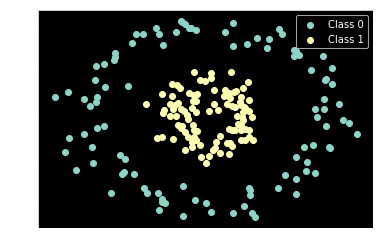

In [2]:
from sklearn.datasets import make_circles

X, classes = make_circles(n_samples=200, factor=0.3, noise=0.1)
plt.scatter(X[classes == 0,0], X[classes == 0,1], label="Class 0")
plt.scatter(X[classes == 1,0], X[classes == 1,1], label="Class 1")
plt.legend()
plt.show()

Our neural network will consist of an input layer, one hidden layer, and an output layer. Since our data are two-dimensional, we will have two neurons in the input layer (one for $x$ coordinates, another for $y$ coordinates). We'll put $16$ neurons in the hidden layer, and one neuron in the output layer. The output of the network will be an estimated probability (in the range $[0,1]$) that the data point is in class 0.

In [3]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

ModuleNotFoundError: No module named 'keras'

Instead of repeatedly calling `model.add()`, you can give Keras the layers you want to have in your neural net when you call `Sequential()`.

In [ ]:
layers = [
    Dense(16, activation='relu'),
    Dense(1,  activation='sigmoid')
]

model = Sequential(layers)

Now let's train the network! Our first step is to call `model.compile`. The `compile` function allows us to make some configurations before we start training. We can do things like

* Choose a [loss function](https://keras.io/losses/), which helps us score how good our neural net is
* Set which [optimizer](https://keras.io/optimizers/) we'll use to minimize the loss function
* Set options that will be used on the backend (in this case, by TensorFlow) beneath the Keras API.

For more information on compilation options, see the [getting started guide](https://keras.io/getting-started/sequential-model-guide/#compilation) or the [Keras documentation](https://keras.io/models/model/#compile).

In [ ]:
"""
Options:
    loss='binary_crossentropy'
        - Loss function for classification problems with two classes.
        - If we had more than one class, we'd use 'categorical_crossentropy' instead

    optimizer='rmsprop'
        - Tells Keras to use the RMSProp optimization routine
        - Reference: https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

    metrics=['accuracy']
        - When we're training our neural net, Keras will tell us how accurate the net
          currently is at making correct predictions.
"""
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Now that the model has been compiled, you can run `model.fit` to actually train the neural network. When you call `model.fit`, you provide a few parameters (such as `epochs` and `steps_per_epoch`) that tell Keras how much training you want to do. In the code below, we do $5$ training epochs each consisting of $512$ training steps, totalling $5\times 512 = 2560$ steps of neural network training.

In [ ]:
"""
model.fit takes two numpy arrays. The first is the array X, which contains the actual
data. The second is an array y that contains the predictions we are trying to make. Since
this is a classification problem with two classes ("blue" and "orange"), y should contain
0's and 1's (where 0 = blue, 1 = orange).

Options:
    epochs=5
        - Each 'epoch' can be thought of as a unit of training, consisting of
          many small training steps
        - The number of training steps in each epoch is controlled by 
          steps_per_epoch

    steps_per_epoch=512
        - Number of training steps to do in each epoch
        - The total number of training steps done when model.fit is called is 
          epochs * steps_per_epoch
     
    verbose=1
        - Tells Keras to show a progress bar for each training epoch that keeps us
          updated on how much the network has been trained.
"""
model.fit(X, classes, epochs=5, steps_per_epoch=512, verbose=1)

Now that your neural network has been trained, you can use `model.predict()` to predict which class a point is in. `model.evaluate()` tells you the value of the loss function and the neural network's accuracy on a dataset.

In [ ]:
# Make predictions with model.predict
predictions = model.predict(X)

# Determine loss and accuracy with model.evaluate
loss, accuracy = model.evaluate(X, classes)

print('%-20s %6.5f' % ('Training loss:', loss))
print('%-20s %6.5f' % ('Training accuracy:', accuracy))

For two-dimensional datasets, we can also plot the decision boundary that allows you to see where a machine learning classifier decides which class a point is in.

In [ ]:
"""
Plot data, and the decision boundary found by the network
"""
fig, axes = plt.subplots(1,2,figsize=(12,6))
for ax in axes:
    ax.scatter(X[classes == 0,0], X[classes == 0,1])
    ax.scatter(X[classes == 1,0], X[classes == 1,1])
    ax.set_xticks([]); ax.set_yticks([])

# plot_decision_boundary is a function I've created that you can
# find in the first code cell in this notebook.
plot_decision_boundary(X, model, axes[1], incr=0.1)
plt.show()

The previous task is an example of a classification problem: given some data and some labels (e.g. "inner circle" and "outer circle"), create a neural network that can look at a new point and predict its label. Regression is another common machine learning task. In a regression problem, you must instead predict a *response variable*, which can take on a continuum of values. For instance, all of the following are regression problems:

* How well will a student score on a standardized test given their grades in school?
* Can we assess how happy a person is (on a scale of 1 - 10) from a sample of their writing?
* Given data about air pressure, temperature, and wind speed, can I predict how much rainfall we will receive?

In [ ]:
x = np.random.uniform(-2, 2, size=(80,1))
y = np.sin(np.pi * x) + np.random.normal(scale=.15, size=(x.size,1))

model = Sequential([
    Dense(32, activation='relu', input_dim=1),
    Dense(32, activation='relu'),
    Dense(8,  activation='relu'),
    Dense(1,  activation='linear')  # Use linear activation in last layer for regression,
])                                  # sigmoid or tanh for classification when there's only
                                    # one class, and softmax when there's multiple classes

# Since we're doing regression, we're going to use 'mean_squared_error' as
# our loss function
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(x, y, steps_per_epoch=256, epochs=4)

fig = plt.figure(figsize=(6,6))
xx  = np.linspace(x.min(), x.max(), num=100)
plt.scatter(x,y)
plt.plot(xx, model.predict(xx), color='r', label='Neural net predictions')
plt.legend()
plt.show()

# Adding regularization <a id="regularization"></a>
Neural networks are such a power machine learning tool that they can occasionally be a little _too_ powerful. In the [second workshop of this series](https://nbviewer.jupyter.org/github/wshand/Python-Data-Science-Workshop/blob/master/2.%20Intro%20to%20Machine%20Learning%20in%20Python%20with%20Scikit-learn.ipynb), we discussed how a machine learning method can get a great score with the data it was trained on and still fail in the real world. Neural networks also do well with training data, but -- if improperly constructed -- are poor at making predictions for data they've never seen before.

As a demonstration, we're going to try another very simple regression problem, like we did in the previous section. However, we're going to use a much more complicated neural net than necessary, consisting of more neurons and layers than we really need:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error

np.random.seed(0)

"""
Create some example data
"""
x = np.random.uniform(-1, 1, size=(60,1))
y = x + np.random.normal(scale=.15, size=x.shape)

# Split into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

"""
Train a complicated neural network on the data
"""
model = Sequential([
    Dense(128, activation='relu', input_dim=1),
    Dense(64,  activation='relu'),
    Dense(32,  activation='relu'),
    Dense(1,   activation='linear')
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=3, steps_per_epoch=512, verbose=1)

"""
Perform linear regression
"""
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

"""
Compare the two models
"""
lm_vs_ann_helper(x_train, y_train, x_test, y_test, linear_model, model)

Here's the output I got on one run of the code cell above:

> ```
Epoch 1/3
512/512 [==============================] - 5s 9ms/step - loss: 0.0213
Epoch 2/3
512/512 [==============================] - 2s 3ms/step - loss: 0.0132
Epoch 3/3
512/512 [==============================] - 2s 3ms/step - loss: 0.0116
ANN training loss:          0.0109
ANN testing loss:           0.0386
Linear model training loss: 0.0215
Linear model testing loss:  0.0188```

The mean squared error received by the ANN on the data it was trained with ($0.0102$) was almost four times better than the MSE on the testing data ($0.0386$), which it hadn't seen before. Meanwhile, fitting a line to the same training data via linear regression got an error on the testing data of $0.0188$, less than half of what the ANN got on that data.

The problem of getting a much better score on the training data than the testing data is known as *overfitting*. Neural networks can be especially prone to overfitting.

There are two ways to prevent overfitting your training data:

* make your neural net simpler; or
* add regularization to your ANN.

If your neural net is doing much better on the training data than the testing data, simplifying your network's architecture is the easiest fix to try. In the code cell below, I try a neural net with only two layers and far fewer neurons.

In [ ]:
"""
Use a much simpler neural net on this data
"""
model = Sequential([
    Dense(4, activation='relu', input_dim=1),
    Dense(1, activation='linear')
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=3, steps_per_epoch=512, verbose=1)

lm_vs_ann_helper(x_train, y_train, x_test, y_test, linear_model, model)

The pattern learned by the simplified neural net in this case is much closer to what we got with the linear model. Now we do much better at making predictions for the data we haven't seen before.

However, simplifying your network isn't usually the best way to try to prevent overfitting. First, it's difficult to tell what part of the network you need to simplify. Moreover, it decreases the predictive power of your neural net.

A better method is to use _regularization_. A regularizer is a method for controlling the growth of the weights in your neural network as you train it. This is useful because in general overfitting occurs due to various oddities that occur to the weights as you train your ANN:

* Some weights grow very large. This usually indicates that your neural net learned some strange feature that only occurred by chance via random noise in the training data.
* One layer might overemphasize the importance of a few neurons in the previous layers, and ignore the rest of the neurons.

To fix the first problem, we change our loss function from

$$
\text{loss function} = \text{numerical penalty on incorrect predictions}
$$

to

$$
\text{loss function} = \text{numerical penalty on incorrect predictions} + \text{penalty on size of weights}
$$

The most common penalties to apply here are known as $L^1$ and $L^2$ regularization. If $\mathcal{W}$ is the set of all of the weights in the network, then

\begin{align*}
L^1 \text{ regularization:} & & \text{penalty on size of weights} & = \lambda\sum_{w_i\in\mathcal{W}} |w_i| \\
L^2 \text{ regularization:} & & \text{penalty on size of weights} & = \lambda\sum_{w_i\in\mathcal{W}} |w_i|^2
\end{align*}

where $\lambda > 0$ is some number chosen by the designer of the ANN.

To fix the second problem, we can use a regularizer known as _dropout_ ([Hinton et al, 2012](https://arxiv.org/abs/1207.0580)). A dropout layer takes the inputs from the previous layer and randomly sets some fraction of them to zero before passing them to the next layer. This prevents the neural net from only relying on a few neurons in each layer -- the outputs of those neurons could be set to zero by a dropout layer and then the ANN wouldn't be able to use their outputs any more.

In [ ]:
from keras.layers       import Dropout
from keras.regularizers import l1

# Same neural net as before, but with some added regularization
model = Sequential([
    # Add some L^2 regularization to keep the weights in the first layer down
    Dense(128, activation='relu', input_dim=1, activity_regularizer=l1(1e-5)),
    
    # Randomly drop 50% of the inputs from the previous layer
    Dropout(0.5),
    Dense(64,  activation='relu', activity_regularizer=l1(1.6e-4)),
    
    # Randomly drop 50% of the inputs from the previous layer
    Dropout(0.5),
    Dense(32,  activation='relu', activity_regularizer=l1(8e-5)),
    
    # By suggestion of Hinton, don't apply dropout to the output layer
    Dense(1, activation='linear')
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=3, steps_per_epoch=512, verbose=1)

lm_vs_ann_helper(x_train, y_train, x_test, y_test, linear_model, model)

The neural net is still overfitting a little bit, but clearly it's doing better than the original version.

## Aside: choosing hyperparameters
A _hyperparameter_ is a number that must be chosen by the creator of an ML system that affects how the system learns or is designed. Neural networks have an especially large number of hyperparameters -- you have to choose the number of layers, the size of layers, what activation functions should be used in each layer, how much regularization/dropout to apply, and so on.

A major downside of neural nets is that an ANN's designer has to adjust each of these parameters until they get a reasonably strong machine learner. The number of hyperparameters can also be beneficial: it allows the designer to make the neural net as powerful as they'd like. But even then, the designer still has to find a way to choose good hyperparameters for the network.

* **Suggestions from papers**: the most common way to choose hyperparameters (at least initially) is just to see what experts suggest from past papers. For instance, in his paper introducing dropout, Geoffrey Hinton recommends a dropout rate of $50\%$. There are also papers such as ["Practical recommendations for gradient-based training of deep architectures"](https://arxiv.org/abs/1206.5533v2) by Yoshua Bengio that look at what various heuristics and practical experience say about how you should choose hyperparameters.
* **Manual guess-and-check**: it's easy to adjust some of the parameters, re-train your network, and see how much better or worse your ANN is doing. This isn't always a very fast or effective method, though.
* **Experience**: in some problem domains there may be specific values of hyperparameters that often work better than others. With enough experience building neural nets for this domain it becomes a lot easier to make good guesses about what hyperparameters you should choose.
* **Randomized and grid search**: you can automate the process of hyperparameter selection by choosing some candidate values of each hyperparameter and then iteratively re-training and scoring your neural net on every possible selection of parameters. This is known as _grid search_. You can also just choose some random group of the candidate values, train the ANN, and repeat a few times. This is called _randomized search_. Below I've written some code that uses scikit-learn's `RandomizedSearchCV` class to find good hyperparameters for the regression problem in the last section.

In [ ]:
# A scikit-learn class that helps us choose hyperparameters
from sklearn.model_selection     import RandomizedSearchCV

# Wraps around a neural network so that we can use the scikit-learn API
# to perform grid search.
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(l1_1=0, l1_2=0, l1_3=0):
    # Clear past TensorFlow sessions to prevent GridSearchCV from using too much memory
    # Reference: https://stackoverflow.com/a/42047606
    if backend.backend() == 'tensorflow':
        backend.clear_session()
    
    # Same neural net as before, but with some added regularization
    model = Sequential([
        # Add some L^1 regularization to keep the weights in the first layer down
        Dense(128, activation='relu', input_dim=1, activity_regularizer=l1(l1_1)),

        # Randomly drop 50% of the inputs from the previous layer
        Dropout(0.5),
        Dense(64,  activation='relu', activity_regularizer=l1(l1_2)),

        # Randomly drop 50% of the inputs from the previous layer
        Dropout(0.5),
        Dense(32,  activation='relu', activity_regularizer=l1(l1_3)),

        # By suggestion of Hinton, don't apply dropout to the output layer
        Dense(1, activation='linear')
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

clf = KerasRegressor(build_fn=create_model, verbose=0)
l1_params = [2**n * 1e-5 for n in range(8)]
param_grid = dict(l1_1=l1_params, l1_2=l1_params, l1_3=l1_params)

# Apply grid search
grid = RandomizedSearchCV(clf, param_distributions=param_grid, n_jobs=4, cv=3,
                          verbose=1, n_iter=30)
grid.fit(x,y)

# What were the best hyperparameters that we found?
print(grid.best_params_)

# Computer vision: building convolutional networks for the MNIST dataset <a id="cnn-mnist"></a>
Let's start looking at how neural networks are used for analyzing image data. We're going to use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), a classic computer vision dataset containing images of tens of thousands of handwritten digits. The MNIST dataset can actually be loaded into Python using Keras:

```python
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
```

We will build a neural network that will be able to look at an MNIST digit tell us what number it sees. To help shorten training times we're only going to look at the digits $0$, $1$, and $2$; you can build a network that classifies more digits by increasing `n_mnist_classes` below.

In [ ]:
########################################################################
### For purpose of demonstration we're not going to use all of  ########
### the digits. Increase n_mnist classes if you want to try     ########
### training your neural net on more types of digits.           ########
########################################################################

n_mnist_classes = 3

########################################################################
########################################################################

# load_mnist_wrapper brings in the MNIST data with keras.datasets.mnist.load_data()
# and does some useful preprocessing. Check out the first code cell of this notebook
# to see how this works.
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = load_mnist_wrapper(n_classes=
                                                                                  n_mnist_classes)
    
# Show a few randomly selected images
fig, axes = plt.subplots(3, 5, figsize=(8,8))

c = np.random.choice(X_train_mnist.shape[0], axes.size)
digits, classes = X_train_mnist[c], y_train_mnist[c]

for (ax,img,num) in zip(axes.flatten(), digits, classes):
    ax.imshow(img.reshape((28,28)), cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("Digit: " + str(num.argmax()))
plt.show()

You could apply a plain feedforward neural network to this dataset, and you'd get decent results. 

In [ ]:
from sklearn.model_selection import KFold
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils  import to_categorical
from keras        import backend

# Slight modification of architecture from the following example in the
# Keras repository:
# https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
mnist_model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(.5),
    Dense(n_mnist_classes, activation='softmax')
])

mnist_model.compile(loss='categorical_crossentropy', optimizer='adadelta',
                    metrics=['accuracy'])
mnist_model.fit(X_train_mnist, y_train_mnist, verbose=1, batch_size=256,
                epochs=1, validation_data=(X_test_mnist, y_test_mnist))

score = mnist_model.evaluate(X_test_mnist, y_test_mnist, verbose=0)
print('Test loss: %.4f'     % score[0])
print('Test accuracy: %.4f' % score[1])

# If we didn't get 100% classification accuracy, show some images that we
# misclassified
predictions = mnist_model.predict(X_test_mnist).argmax(axis=1)
mclf_idx    = (predictions != y_test_mnist.argmax(axis=1)).flatten()
X_mclf      = X_test_mnist[mclf_idx]
y_mclf      = y_test_mnist[mclf_idx]
pred_mclf   = predictions[mclf_idx]

print("On test set, misclassified %d out of %d" % (X_mclf.shape[0], predictions.size))

if X_mclf.shape[0] >= 3:
    fig, axes   = plt.subplots(1,3,figsize=(8,8))
    c           = np.random.choice(X_mclf.shape[0], 3, replace=False)
    for (ii,ax) in enumerate(axes):
        ax.imshow(X_mclf[c[ii]].reshape((28,28)), cmap='gray')
        ax.set_xticks([]); ax.set_yticks([])
        pred_class, true_class = pred_mclf[c[ii]], y_mclf[c[ii]].argmax()
        ax.set_xlabel("Predicted: " + str(pred_class) + 
                      "\nTrue class: " + str(true_class))

# Saving and loading models <a id="saving"></a>
Neural networks are computationally expensive and require a large amount of time to train. The largest nets can take days to train on hundreds or thousands of specialized hardware units running in parallel. As a result, once you've trained a neural net, you may want to save it so that you can use it later on without having to re-train the network.

Keras allows you to save an ANN to a file and then reload it later on with the `save()` function. When you call `model.save(filename)` Keras stores `model` in an HDF5 file with all the details of the network, including

* the ANN's architecture (i.e. number of layers, nodes per layer, etc.);
* the weights you found by running `model.fit`; and
* the training configuration from `model.compile` (such as what loss function and optimizer you're using).

In [ ]:
### Helper functions ###################################
def plot_circle_anns(X, classes, model, loaded_model):
    fig, axes = plt.subplots(1, 2, figsize=(9,5))
    for (ax,ann) in zip(axes,(model,loaded_model)):
        ax.scatter(X[classes == 0,0], X[classes == 0,1]); ax.set_xticks([])
        ax.scatter(X[classes == 1,0], X[classes == 1,1]); ax.set_yticks([])
        plot_decision_boundary(X, ann, ax, incr=0.1)
    axes[0].set_title("Original model")
    axes[1].set_title("Model loaded from file")
    plt.show()
#########################################################

from keras.models import load_model
    
X, classes = make_circles(n_samples=200, factor=0.3, noise=0.1)

model = Sequential([
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X, classes, epochs=5, steps_per_epoch=512)

"""
Save the ANN as an HDF5 (.h5) file
"""
model.save('keras_circles_ann.h5')

"""
Now load model from disk
"""
loaded_model = load_model('keras_circles_ann.h5')

"""
Show decision boundaries for both ANNs side-by-side, overlaid
on the dataset
"""
plot_circle_anns(X, classes, model, loaded_model)

If everything worked correctly, the left and right plots should be identical.

`model.save` will also save the current training state of the network. This allows you to spend time training a network with `model.fit`, save it, and then come back later and continue training the model. All you have to do is call the `fit` function again:

In [ ]:
# Do five more epochs of training with the model that was loaded
# from the save file
loaded_model.fit(X, classes, epochs=5, steps_per_epoch=512)

plot_circle_anns(X, classes, model, loaded_model)

Another way to use `keras.models.load_model` is to share neural nets with others. For instance, I trained a neural net for the entire MNIST dataset (all 10 digits) using [some example code](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) and added it to the GitHub repository for this workshop. The code cell below downloads this model from the repository (if it isn't already downloaded) and scores it on the MNIST test data.

In [ ]:
################################################################
### This code is just to download the model off the ############
### GitHub repository if you don't already have it  ############
################################################################
import shutil
from urllib.request import urlopen

DOWNLOAD_PATH = os.path.join(os.getcwd(), 'mnist_model.h5')
REPO_PATH     = os.path.join(os.getcwd(), 'assets', 'models', 'mnist_model.h5')
url           = 'https://github.com/wshand/Python-Data-Science-Workshop/blob/'\
                'master/assets/models/mnist_model.h5?raw=true'

if not os.path.isfile(REPO_PATH) and not os.path.isfile(DOWNLOAD_PATH):
    with urlopen(url) as response, open(DOWNLOAD_PATH, 'wb') as f:
        print('Downloading model from', url)
        print('Downloading to', DOWNLOAD_PATH)
        shutil.copyfileobj(response, f)
################################################################

(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = load_mnist_wrapper(n_classes=10)
if os.path.isfile(REPO_PATH):
    model = load_model(REPO_PATH)
else:
    model = load_model(DOWNLOAD_PATH)

score = model.evaluate(X_test_mnist, y_test_mnist, verbose=0)
print('Test loss (all 10 digits): %.4f'     % score[0])
print('Test accuracy (all 10 digits): %.4f' % score[1])

# Visualizing networks with TensorBoard <a id="tensorboard"></a>

In [ ]:
from keras.callbacks import TensorBoard

"""
Clear TensorFlow models that we've made so far
"""
backend.clear_session()

"""
Create directory for storing TensorBoard log files, if it doesn't exist already.
If it does, clear all logs currently in the directory.
"""
LOG_DIR=os.path.join(os.getcwd(), 'ann_keras_log_dir')
print("Using", LOG_DIR, "as directory to store TensorBoard logs")
if not os.path.isdir(LOG_DIR):
    os.mkdir(LOG_DIR)

for f in os.listdir(LOG_DIR):
    file_path = os.path.join(LOG_DIR, f)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

"""
Create circles data
"""
X, classes = make_circles(n_samples=200, factor=0.3, noise=0.1)

"""
Build neural network
"""
model = Sequential([
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
tboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=0,
                    write_graph=True, write_images=True)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

"""
Fit the model. Use a TensorBoard instance as a callback so that we can track
training over time.
"""
model.fit(X, classes, epochs=5, steps_per_epoch=512, verbose=0, callbacks=[tboard])

To start a TensorBoard server, we would usually use the `tensorboard` command in our terminal. So for instance, if `LOG_DIR='/home/ann_keras_log_dir'` in the code above, I would go to my terminal/command line and write

```bash
tensorboard --logdir /home/ann_keras_log_dir
```

to start TensorBoard. For convenience, I've added some Python code below that will do this for you. Run the following code cell and then go visit http://localhost:6006 in your browser.

In [ ]:
# Start TensorBoard server
from tensorboard import program, default

tb = program.TensorBoard(default.get_plugins(), program.get_default_assets_zip_provider())
tb.configure(argv=[None, '--logdir', LOG_DIR])
tb.launch()

# Additional resources <a id="additional-resources"></a>
* [Keras documentation](https://keras.io/)
* [playground.tensorflow.org](https://playground.tensorflow.org/) allows you to experiment with some simple neural nets.
* [Hacker's guide to Neural Networks](https://karpathy.github.io/neuralnets/)
* [Neural Networks and Deep Learning (online book)](http://neuralnetworksanddeeplearning.com/)
* [Deep Learning](http://www.deeplearningbook.org/) -- textbook by Ian Goodfellow, Yoshua Bengio, and Aaron Courville, who are among the top researchers in neural nets
* References for specific ANN architectures:
  * Convolutional networks
  * LSTMs
    * [Understanding LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)  
* [Practical recommendations for gradient-based training of deep architectures](https://arxiv.org/abs/1206.5533v2)